In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt5

In [2]:
import time
time.sleep(5)

In [77]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util, data)
import napari

In [4]:
!pip install joblib

In [5]:
from joblib import parallel_backend

## Import scan and display in napari

In [79]:
with parallel_backend('threading', n_jobs=3):
    scan = io.imread('CC1061-Aa-TOP_stack.tif')
#membranes = io.imread('cells_membrane.tif')

#print("shape: {}".format(nuclei.shape))
#print("dtype: {}".format(nuclei.dtype))
#print("range: ({}, {})".format(np.min(nuclei), np.max(nuclei)))

In [80]:
with parallel_backend('threading', n_jobs=3):
    # Your scikit-learn code here
    viewer = napari.view_image(scan, contrast_limits=[0, 1])

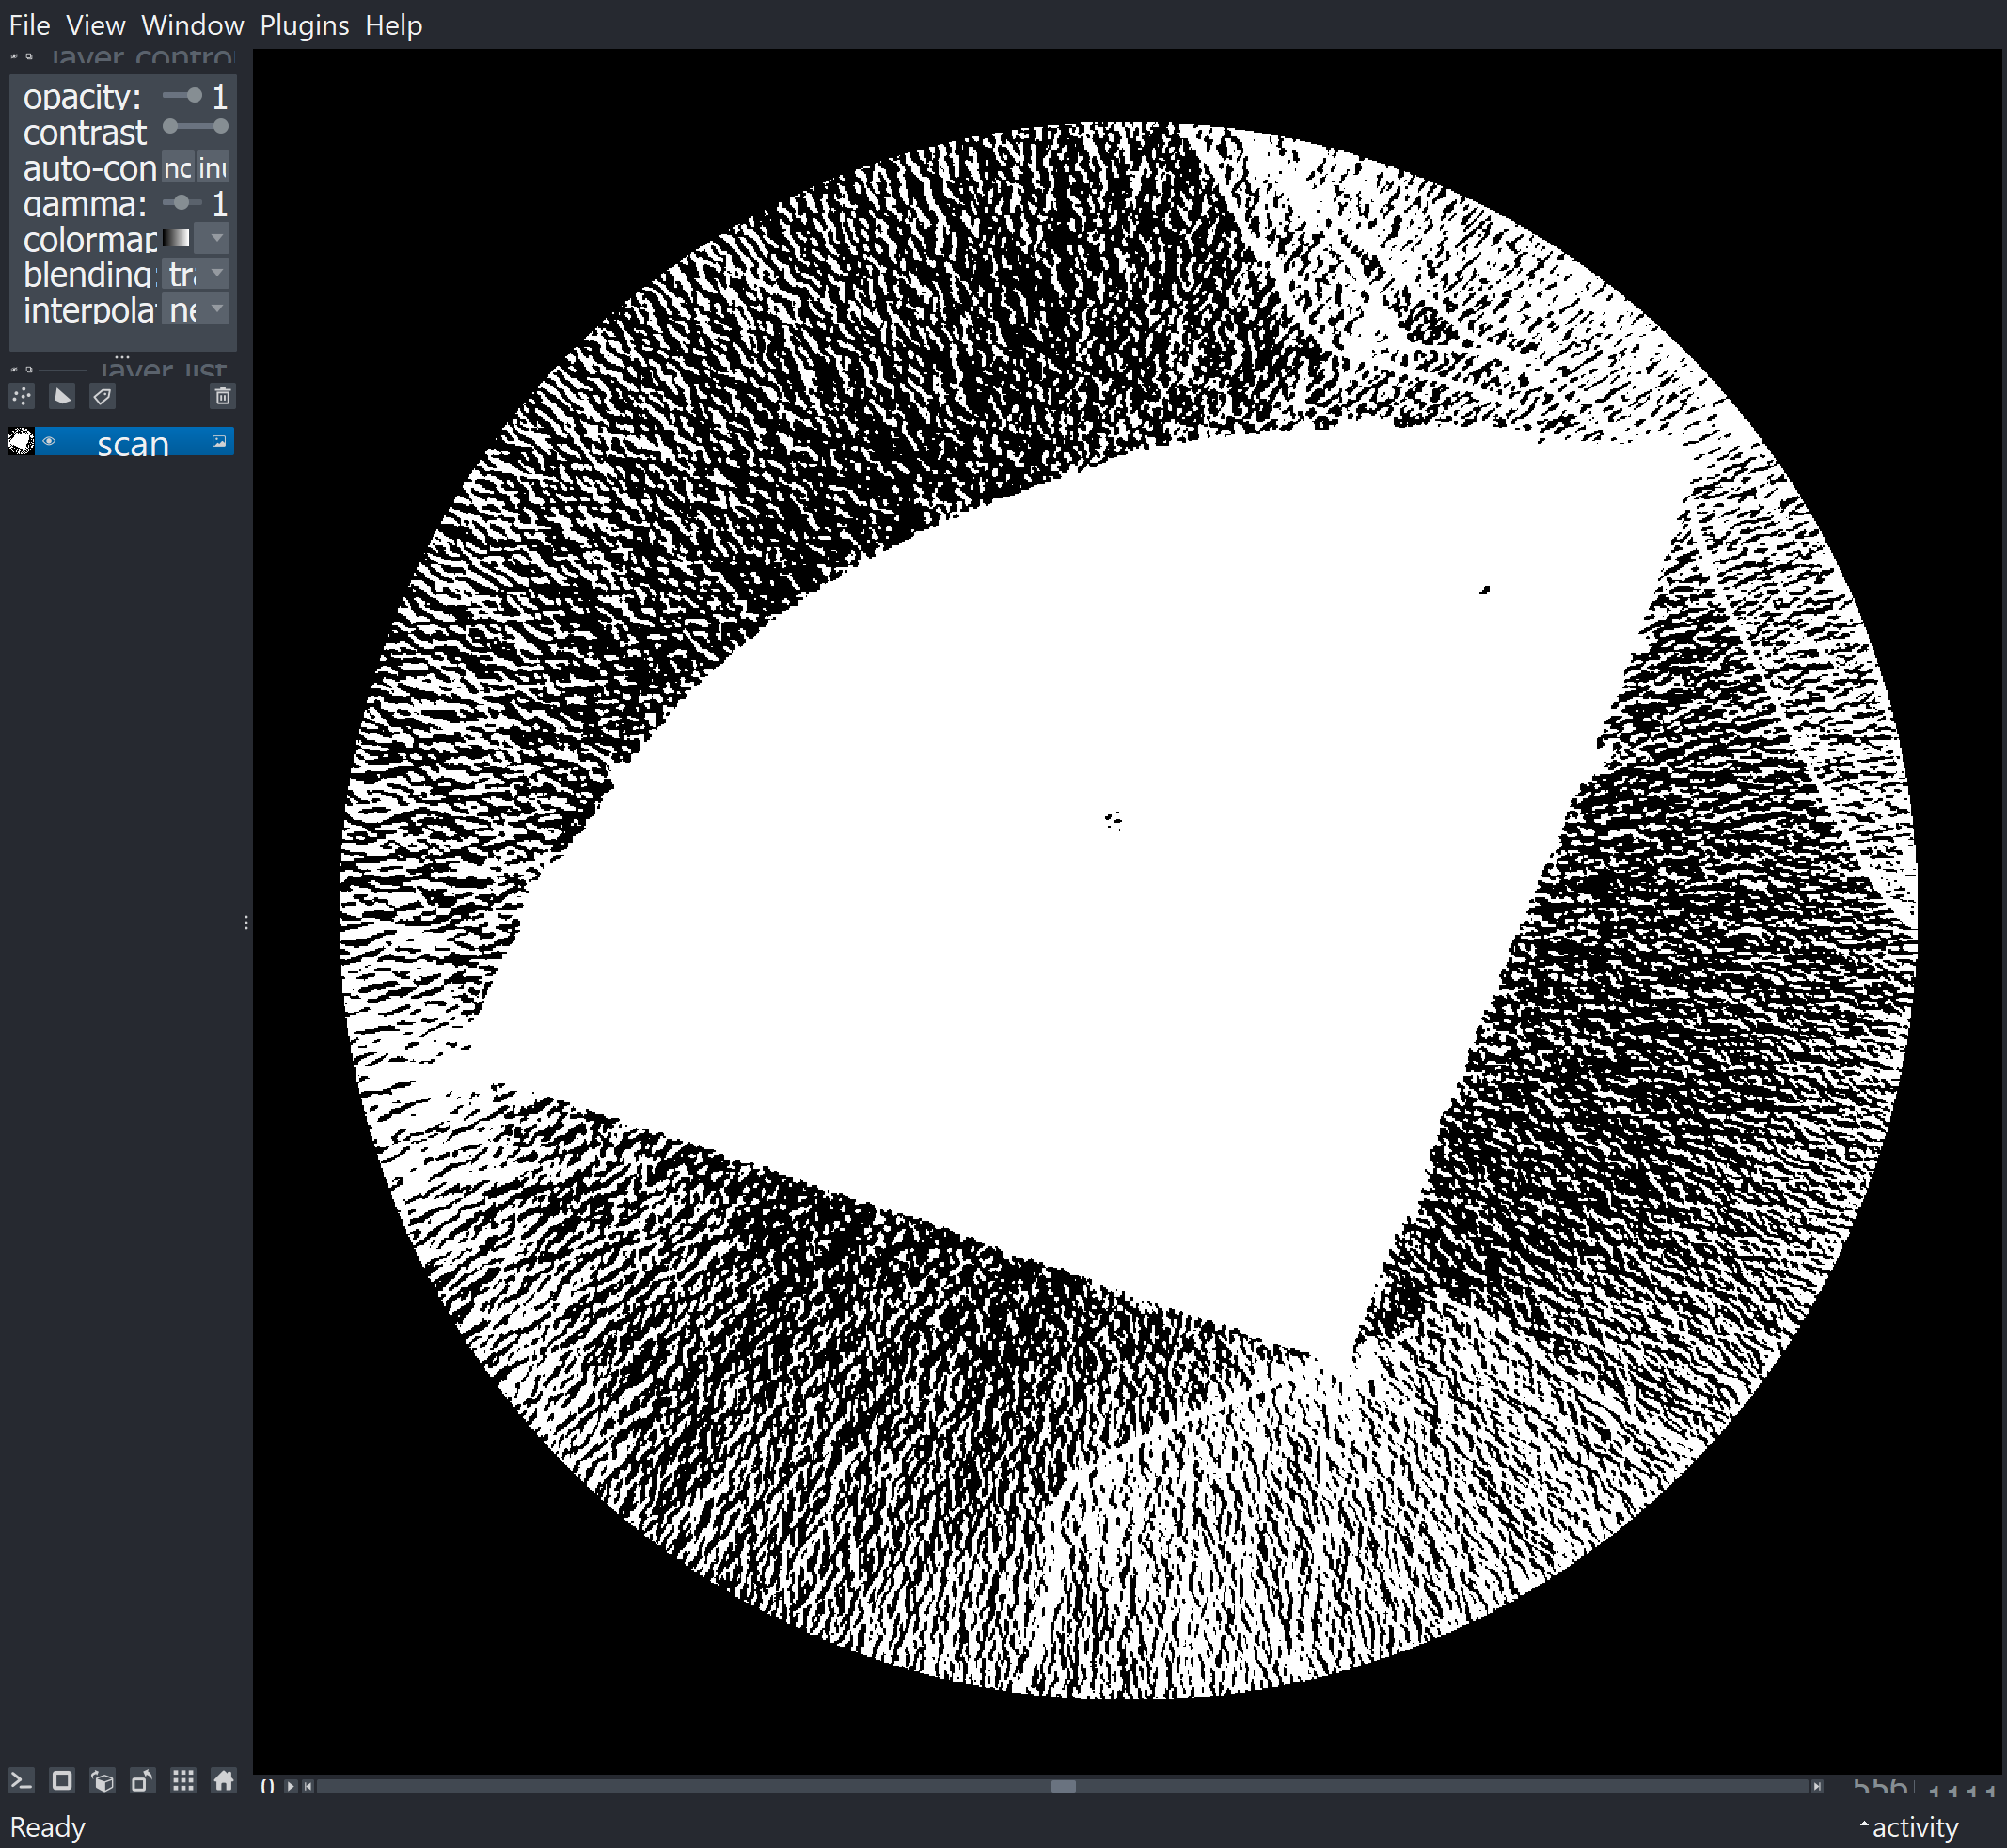

In [81]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer)

## Filter out brightest particles

In [83]:
with parallel_backend('threading', n_jobs=3):
    vmin, vmax = np.quantile(scan, q=(0.005, 0.995))
    
    stretched = exposure.rescale_intensity(
        scan, 
        in_range=(vmin, vmax), 
        out_range=np.float32
    )
    
    viewer.add_image(stretched, contrast_limits=[0, 1], name='stretched')

In [84]:
with parallel_backend('threading', n_jobs=3):
    viewer.dims.set_point(0,1)
    nbscreenshot(viewer)

## Thresholding (see below for automated thresholding)

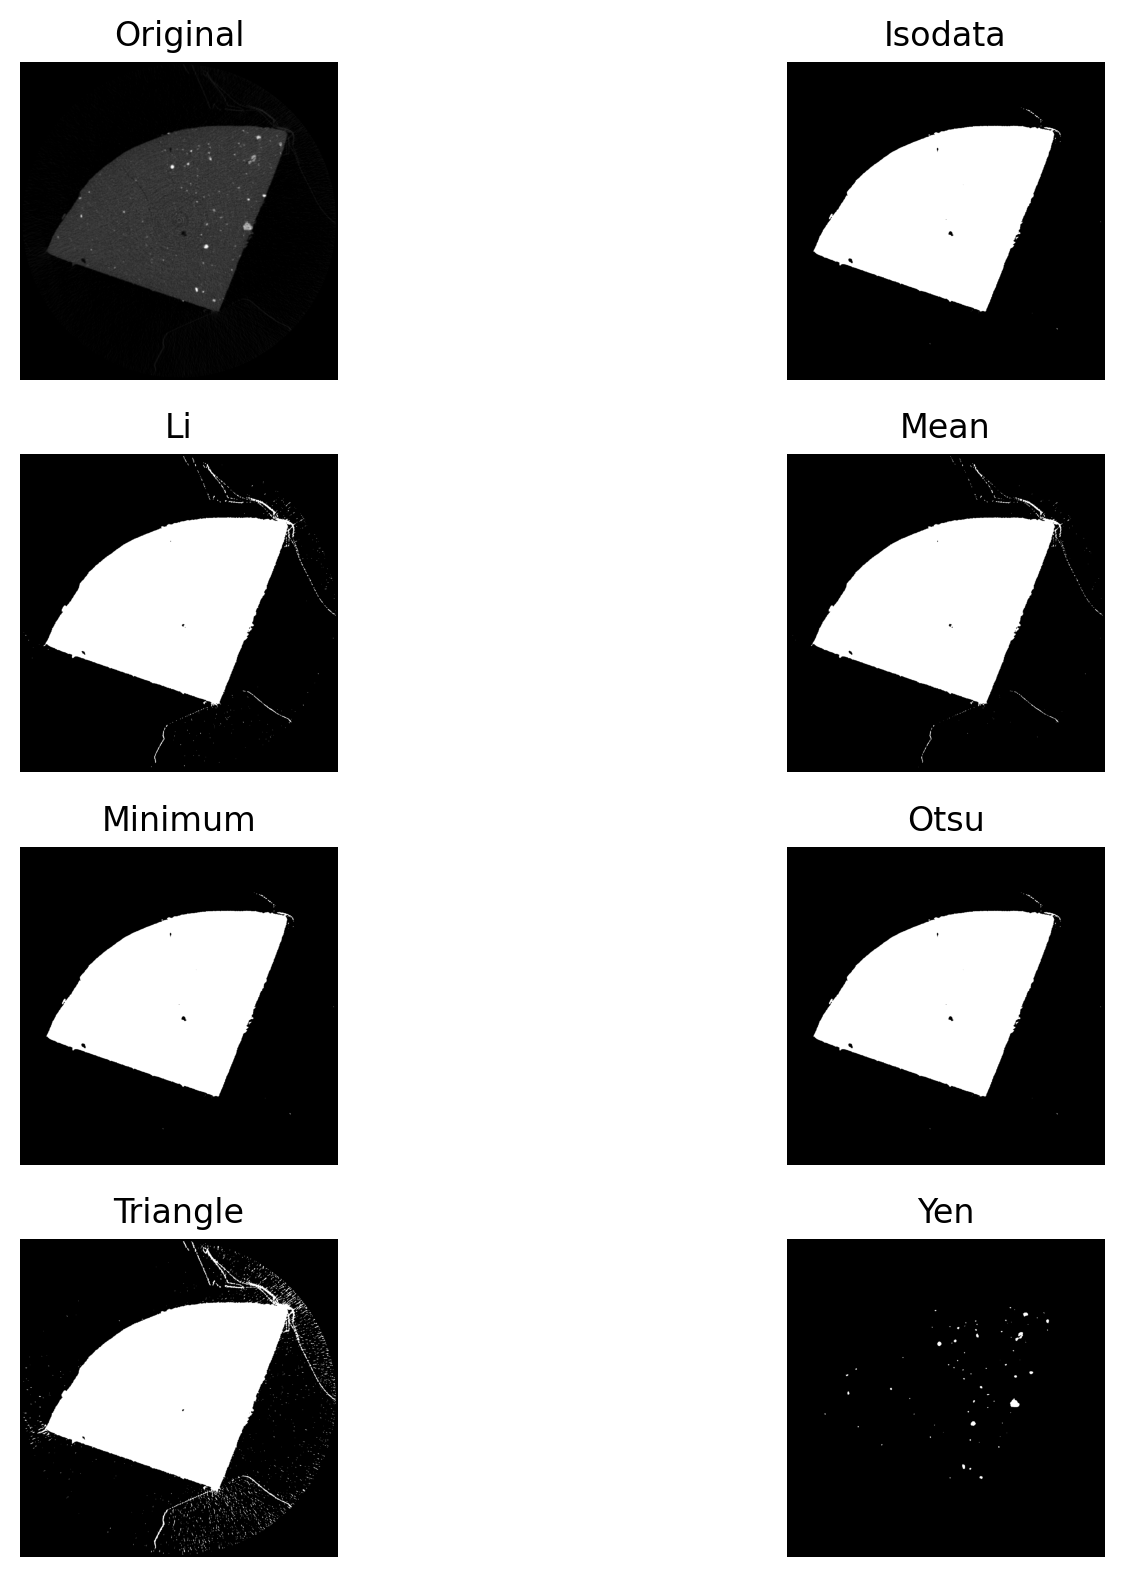

In [314]:
# This cell only works with 2D image

import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import try_all_threshold

scan2 = io.imread('CC1061-Aa-TOP__rec0619.png')
fig, ax = try_all_threshold(scan2, figsize=(10, 8), verbose=False)
plt.show()

In [86]:
with parallel_backend('threading', n_jobs=3):
    denoised = ndi.median_filter(scan, size=3)

In [87]:
with parallel_backend('threading', n_jobs=3):
    yen_thresholded = denoised > filters.threshold_yen(denoised)

In [88]:
viewer.add_image(yen_thresholded, name='thresholded', opacity=1)

<Image layer 'thresholded' at 0x2ac058ae020>

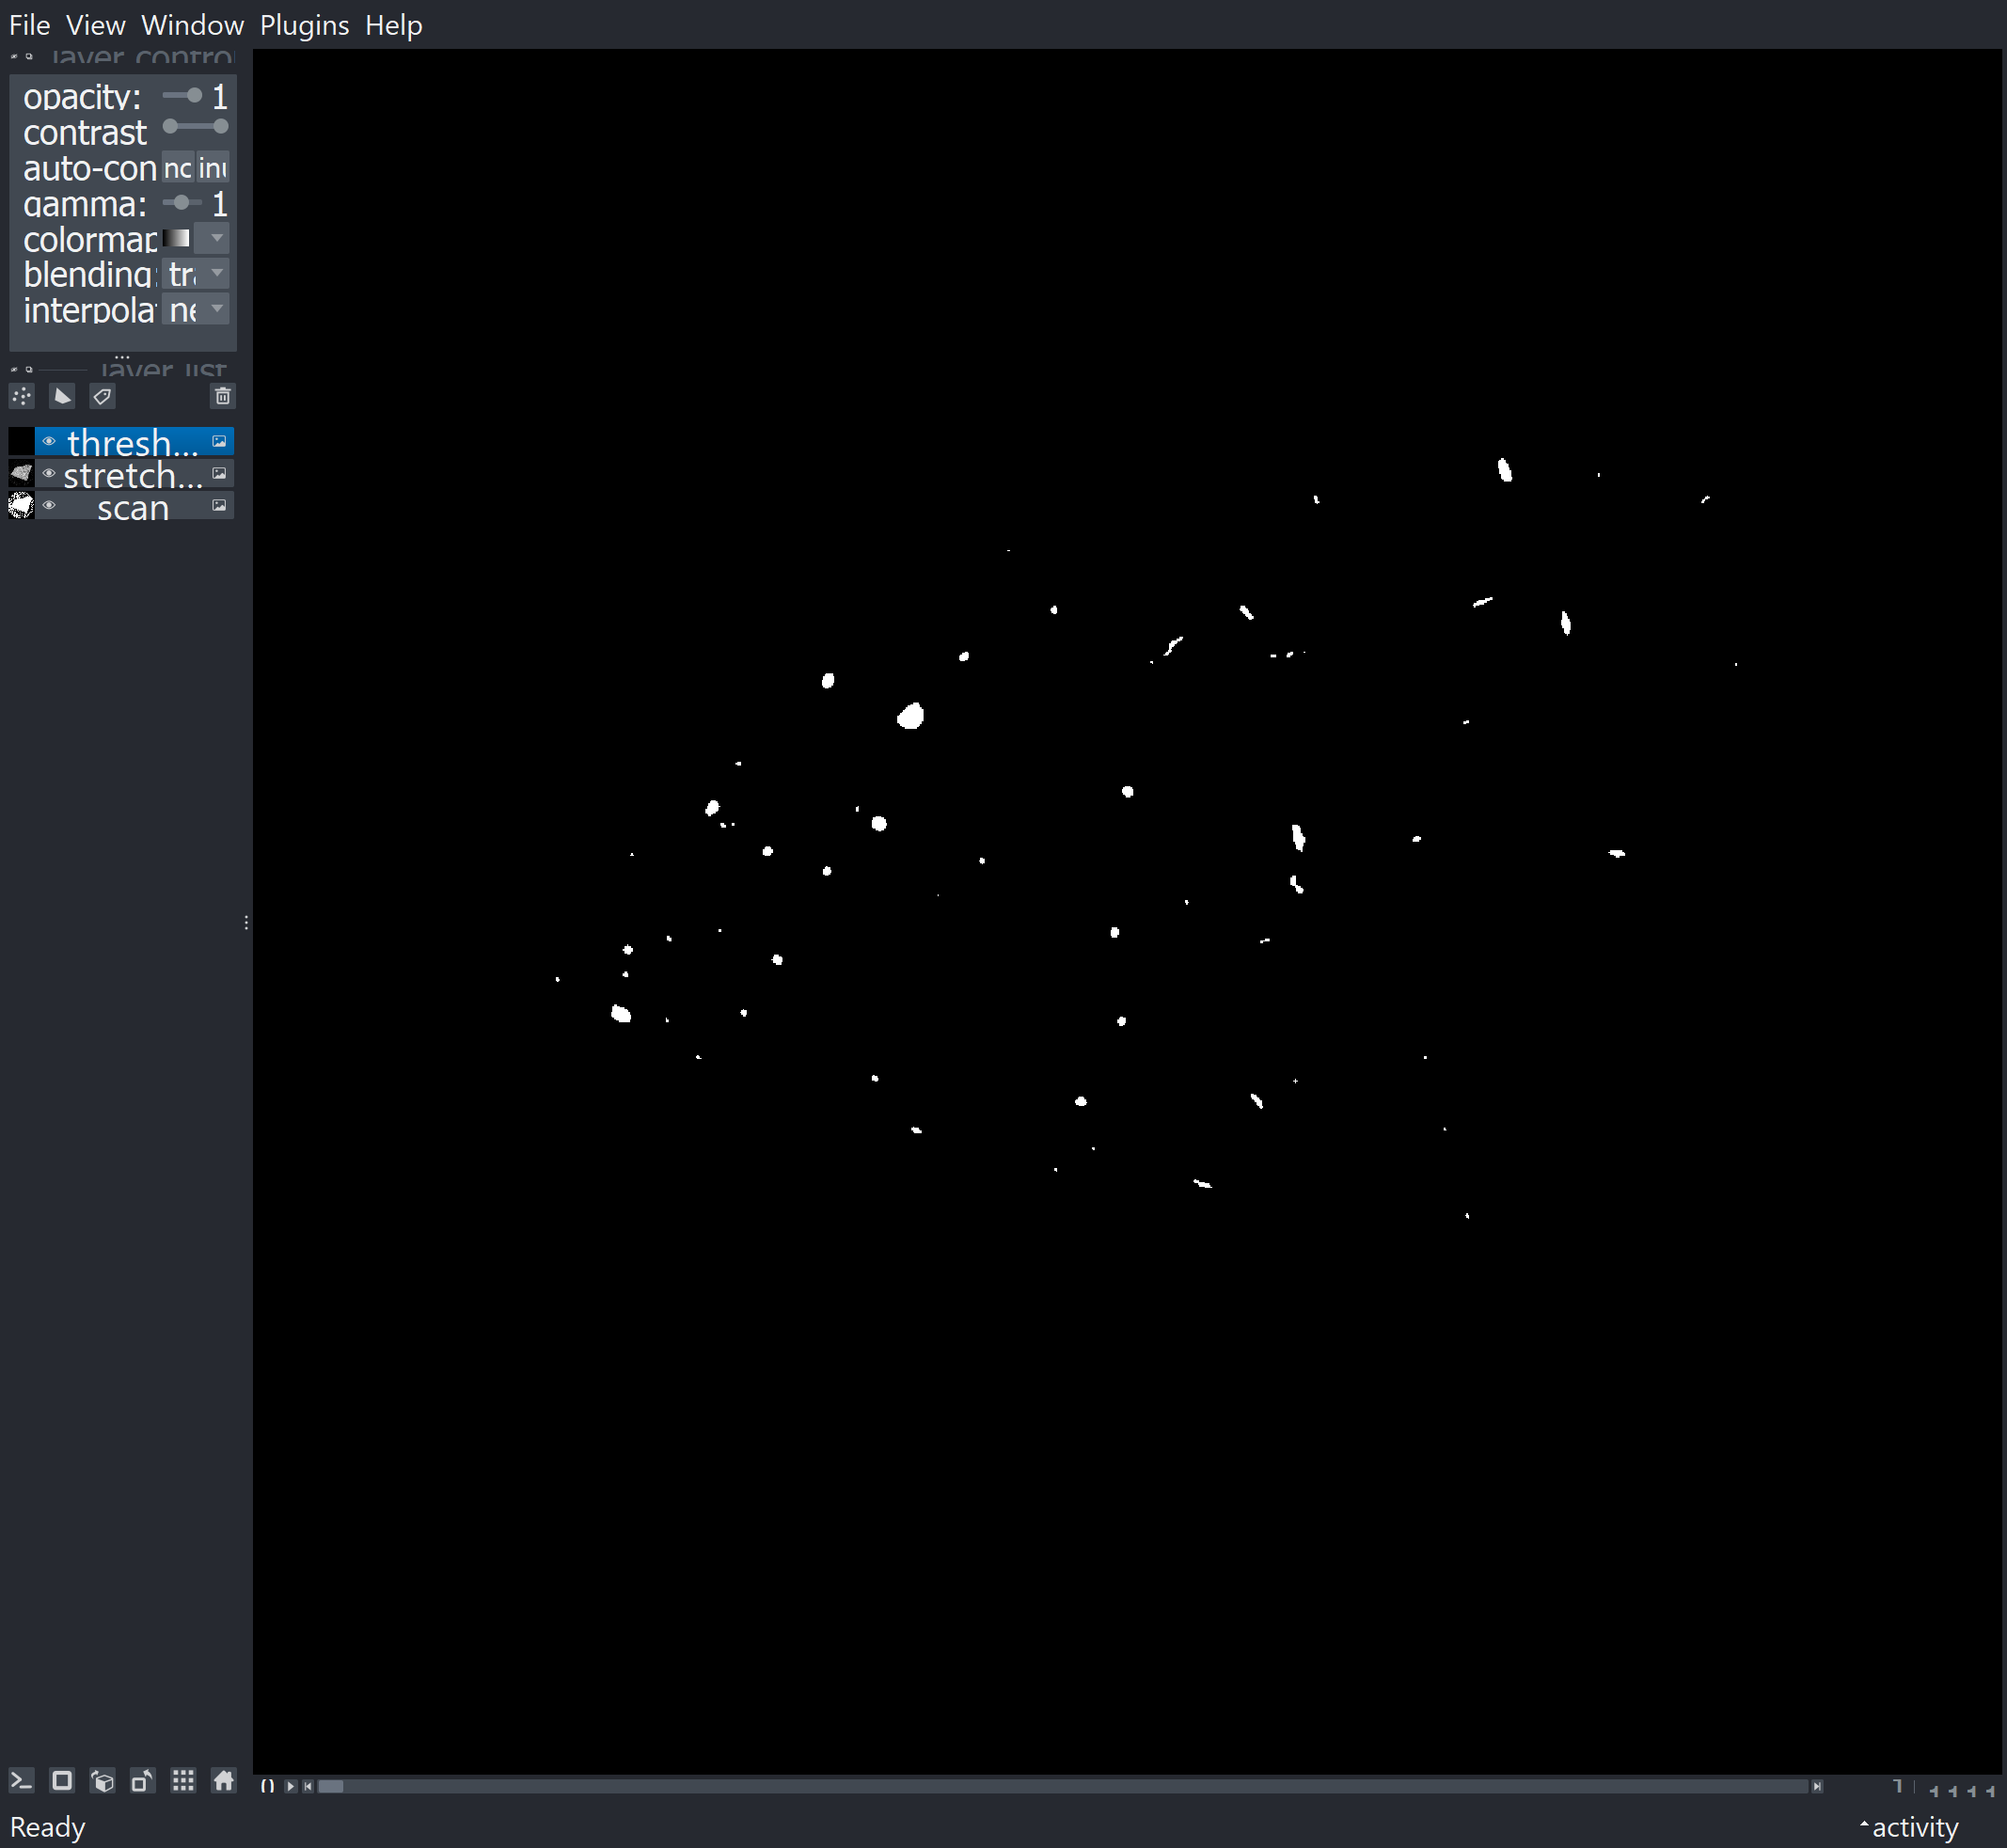

In [89]:
#viewer.dims.set_point(0, center)
nbscreenshot(viewer)

## Rescale

In [90]:
from skimage.transform import rescale

with parallel_backend('threading', n_jobs=3):
    rescaled_scan = rescale(scan, 0.2, mode="reflect", anti_aliasing=False)

## Edge Detection

In [91]:
with parallel_backend('threading', n_jobs=3):
    edges = filters.sobel(rescaled_scan)
    
    viewer = napari.view_image(rescaled_scan, blending='additive', colormap='green', name='scan')
    viewer.add_image(edges, blending='additive', colormap='magenta', name='edges')

In [92]:
with parallel_backend('threading', n_jobs=3):
    viewer.dims.set_point(0, 0)
    nbscreenshot(viewer)

In [93]:
with parallel_backend('threading', n_jobs=3):
    yen_thresholded = rescale(yen_thresholded, 0.2, mode="reflect", anti_aliasing=False)
    filled = ndi.binary_fill_holes(yen_thresholded)
    
    viewer.add_image(filled, name='filled', opacity=0.3)

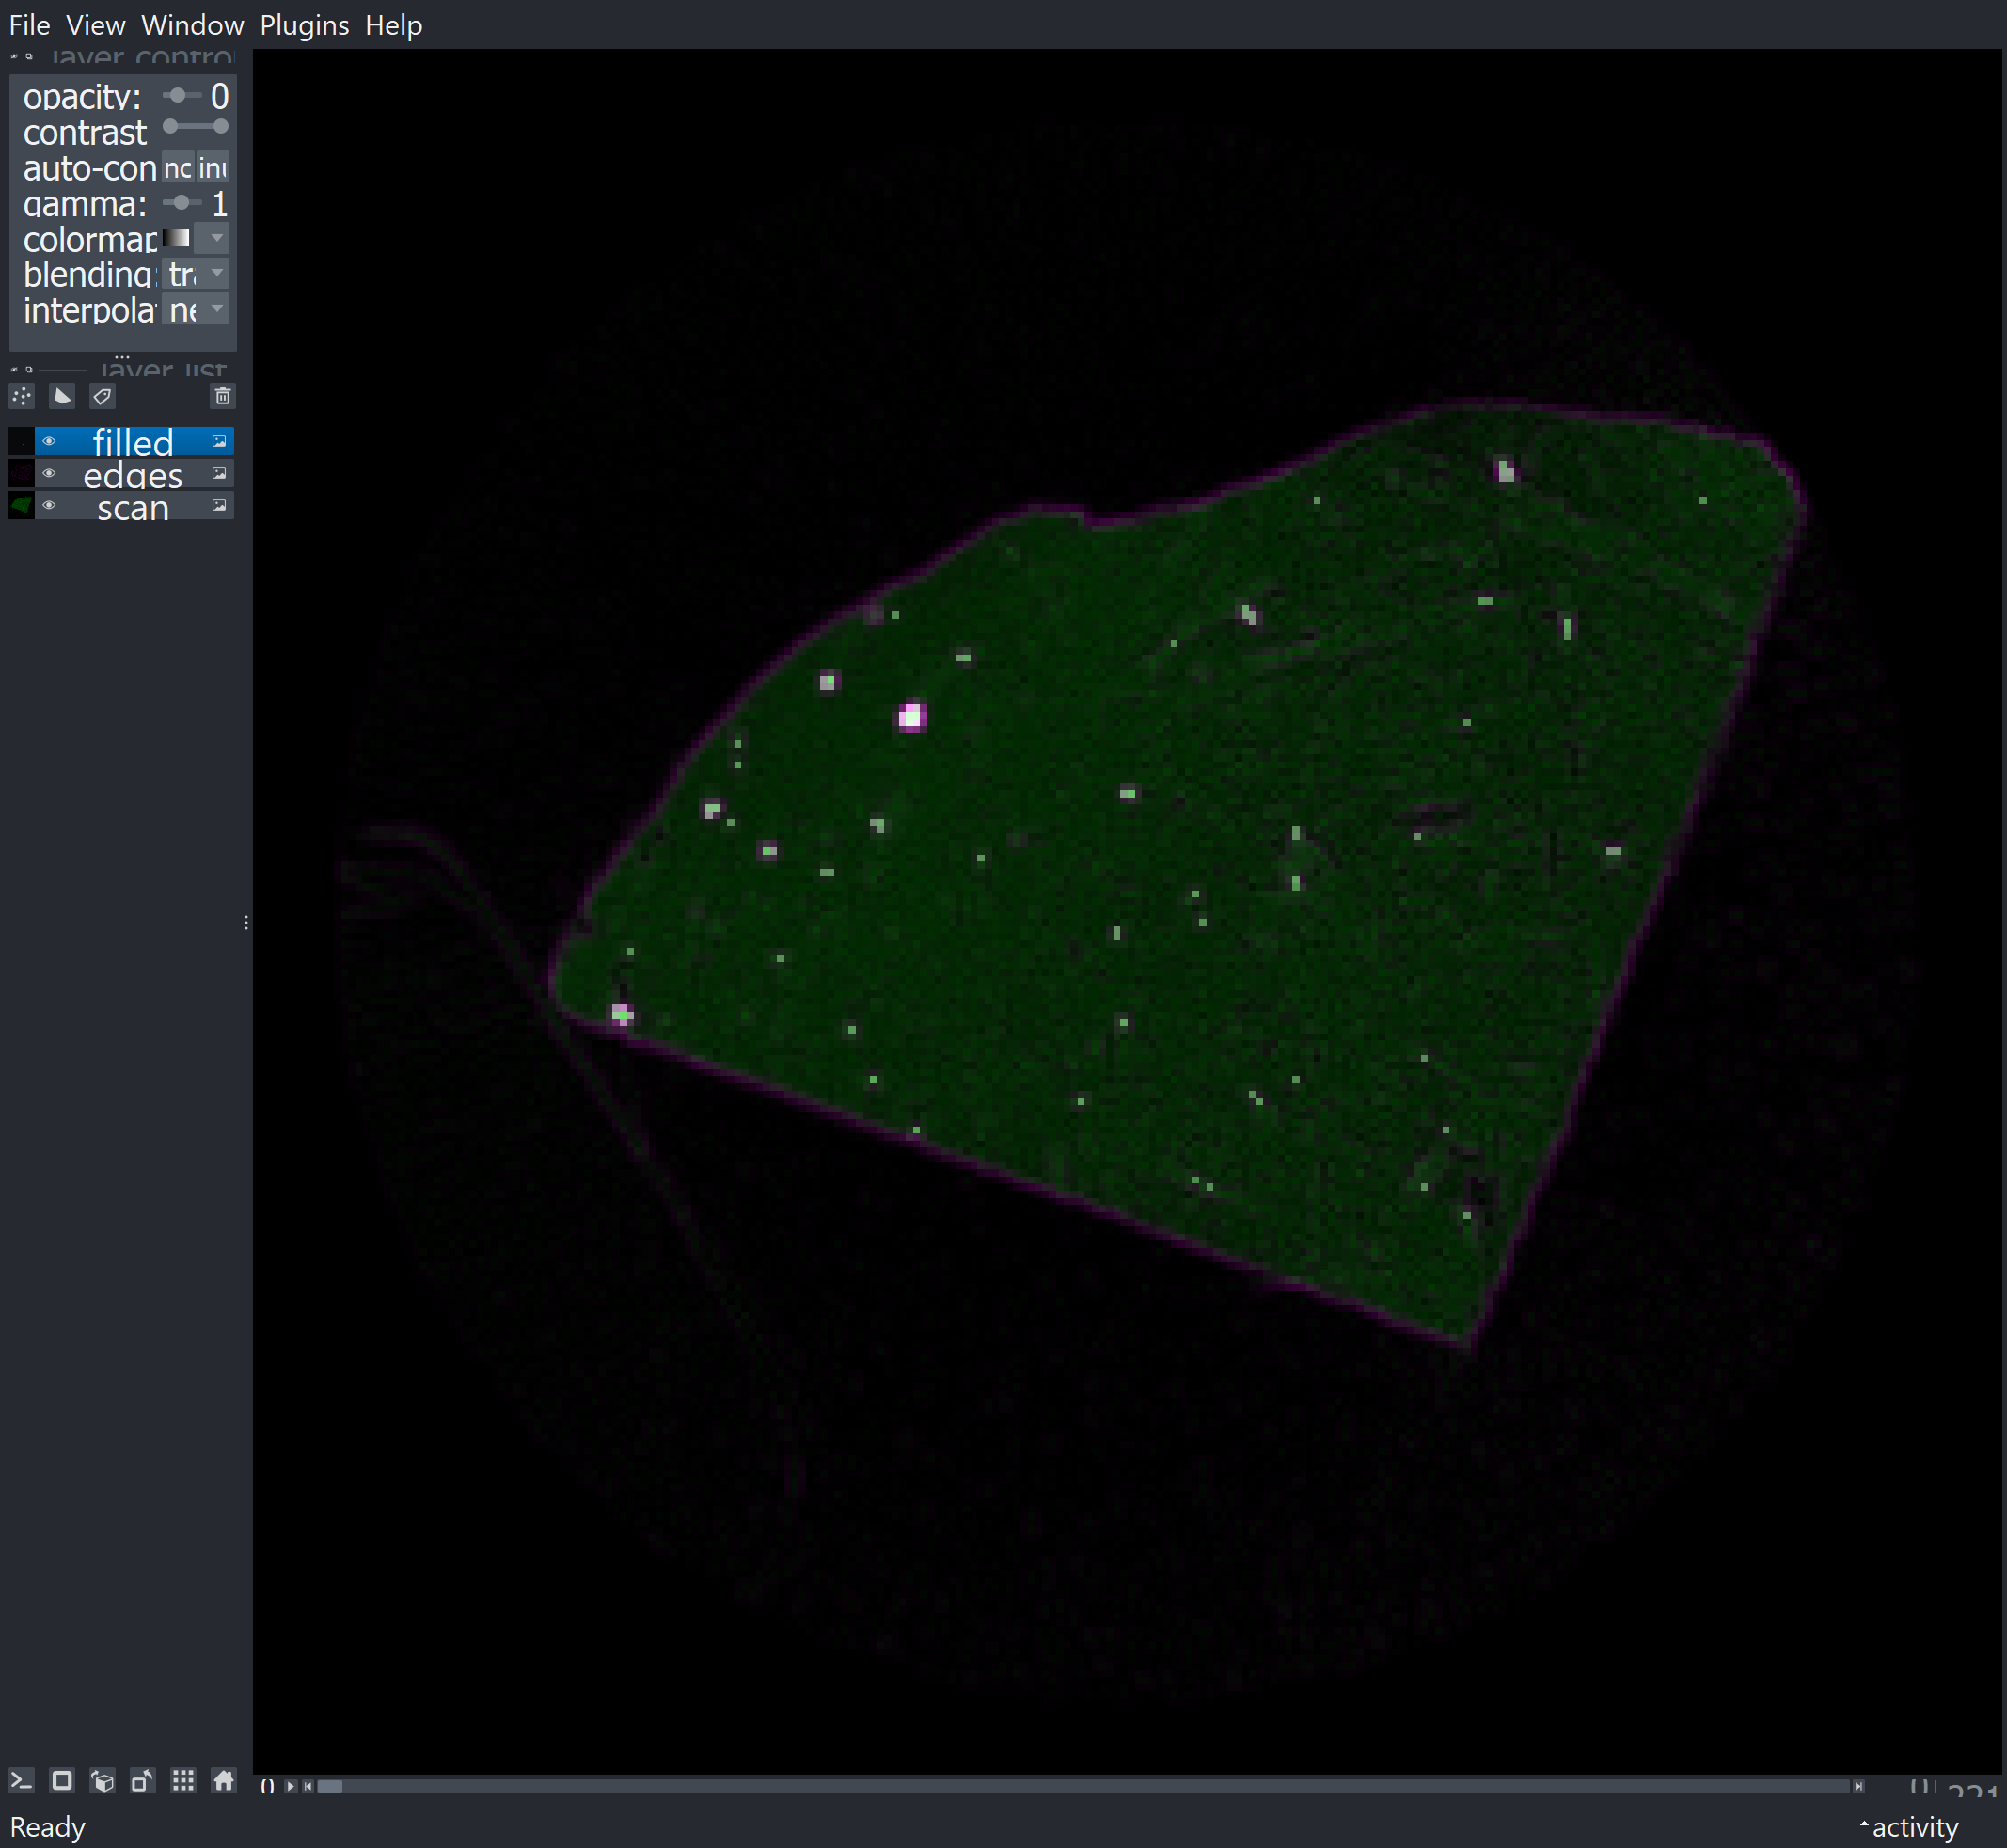

In [94]:
viewer.dims.set_point(0, 0)
nbscreenshot(viewer)

## Create Labels and remove_holes

In [95]:
width = 20

remove_holes = morphology.remove_small_holes(
    filled, 
    area_threshold=width ** 3
)

In [96]:
labels = measure.label(remove_holes)

viewer.add_labels(labels, name='labels')

<Labels layer 'labels' at 0x2acadec80a0>

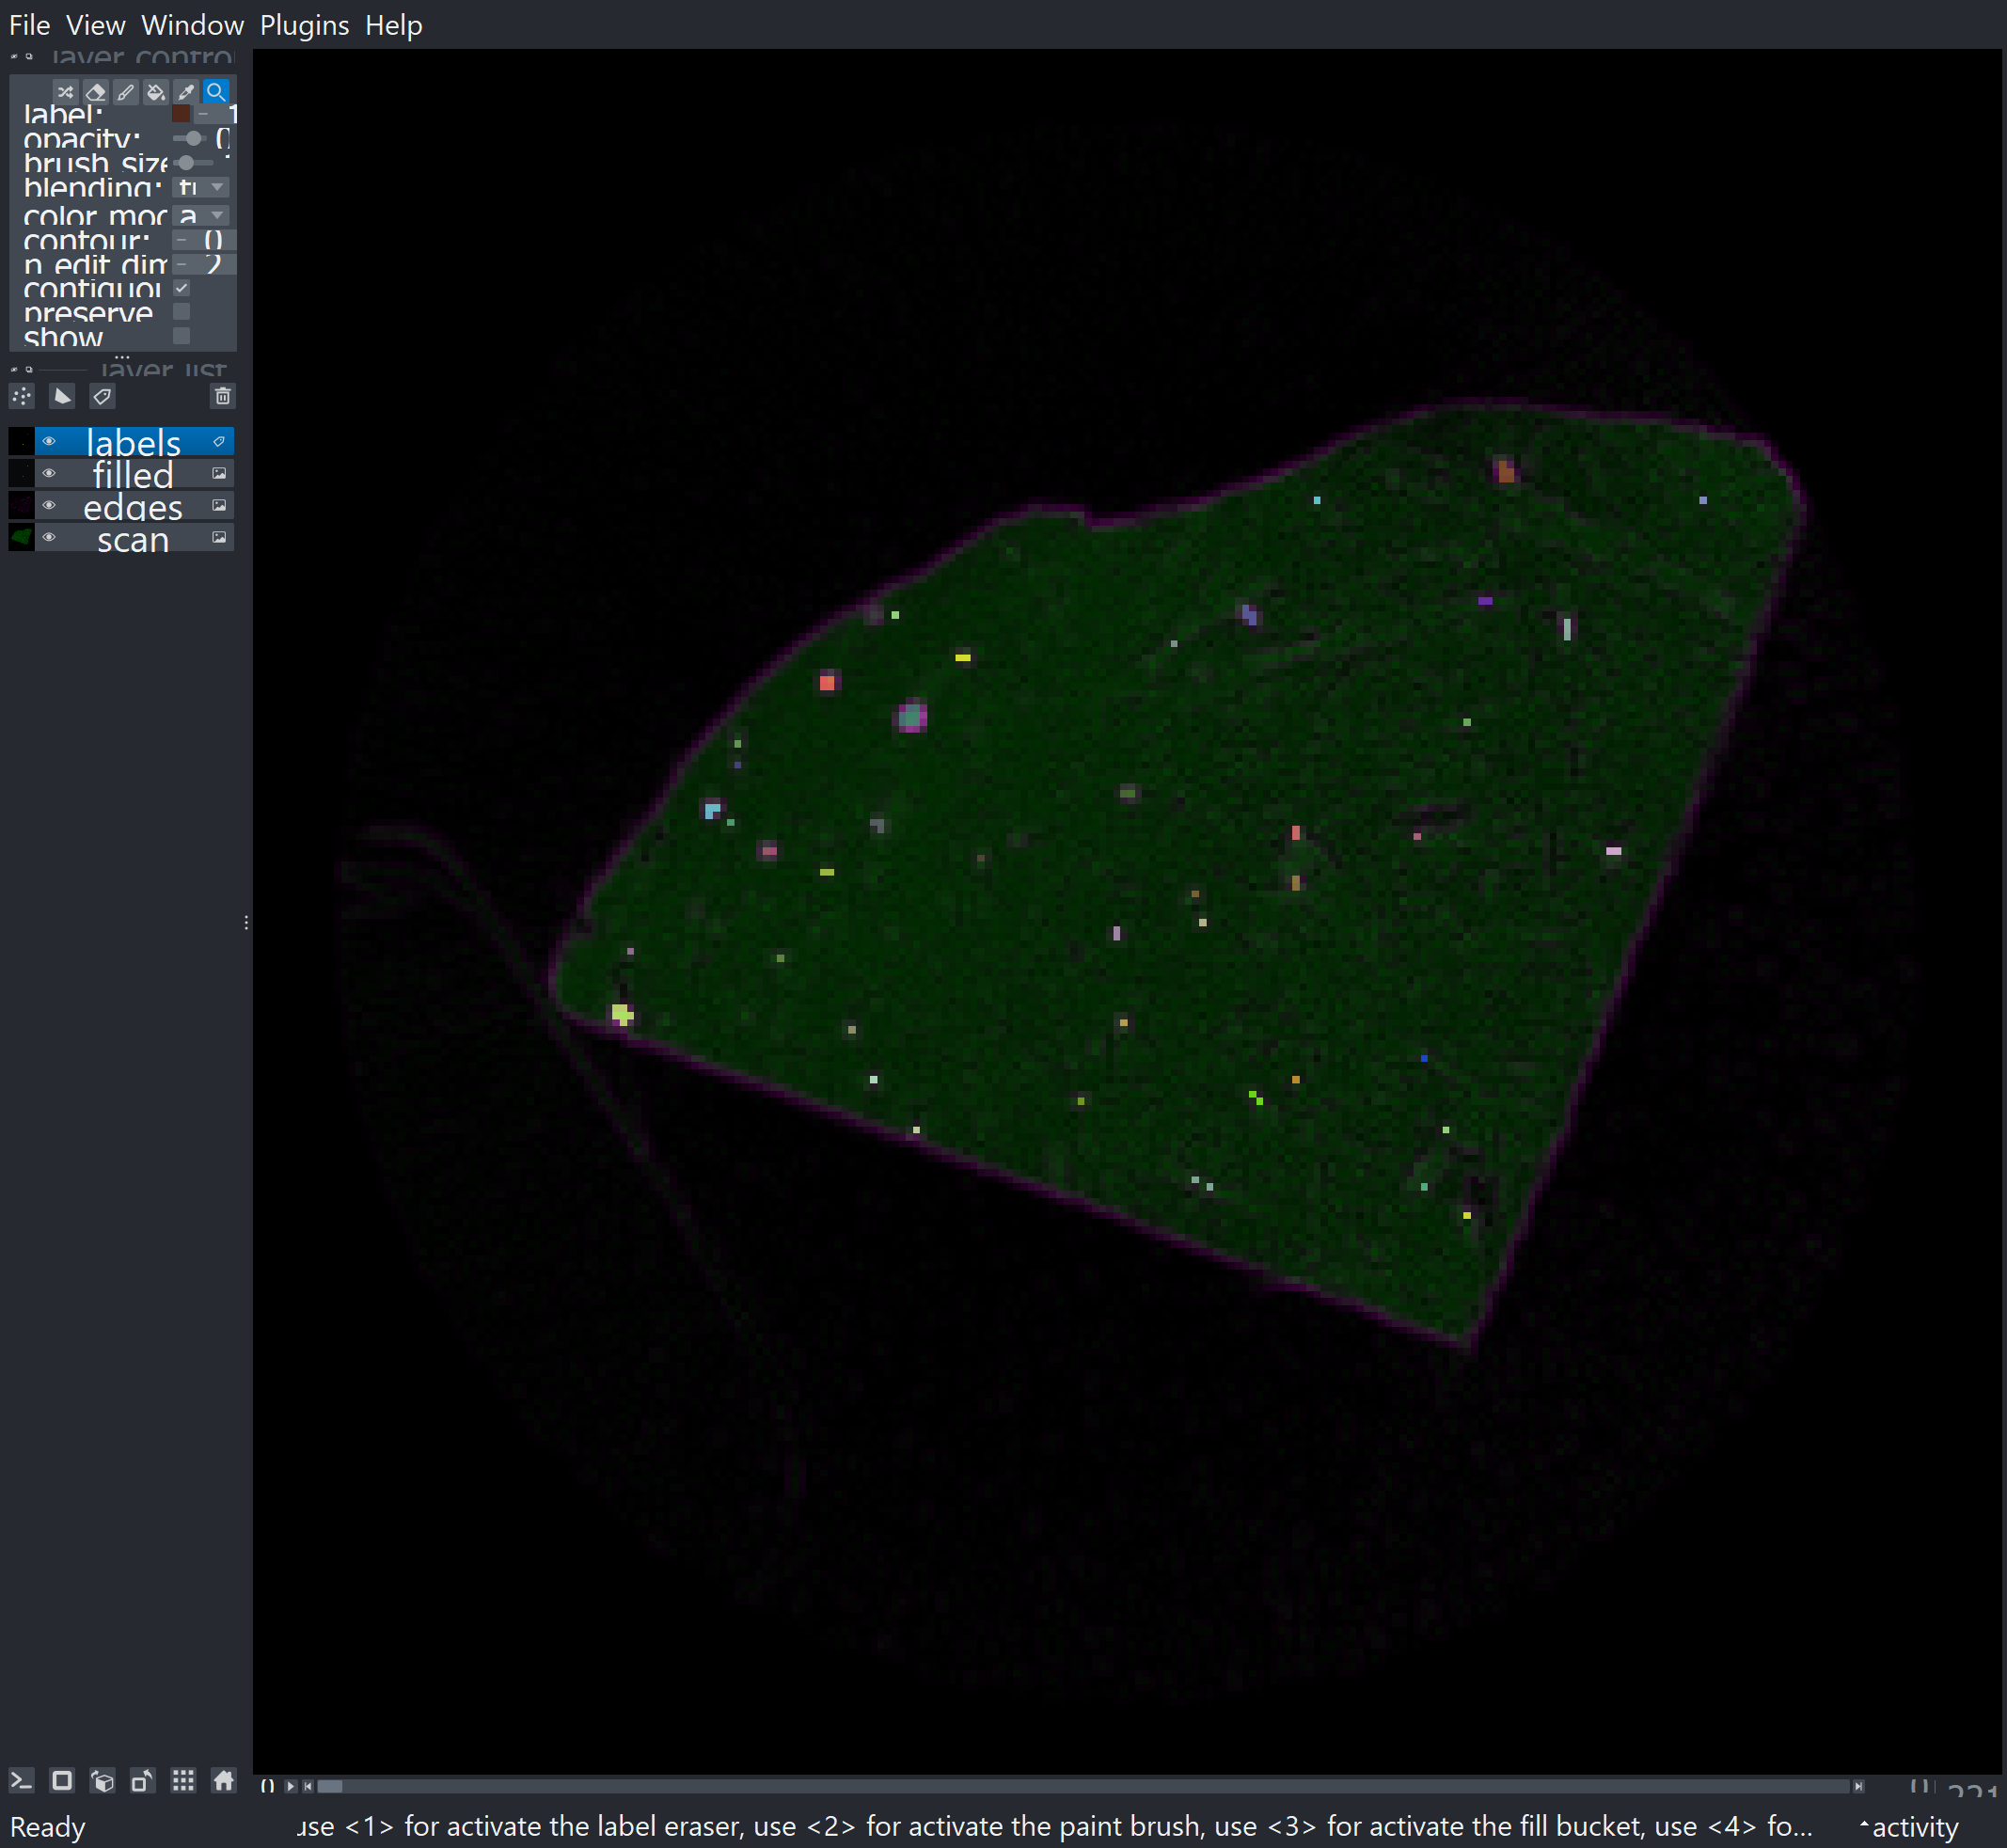

In [97]:
#viewer.dims.set_point(0, 0)
nbscreenshot(viewer)

## Auto labeling

In [42]:
transformed = ndi.distance_transform_edt(remove_holes)

maxima = morphology.local_maxima(transformed)
viewer.add_points(
    np.transpose(np.nonzero(maxima)),
    name='bad points',
    size=4,
    n_dimensional=True,  # points have 3D "extent"
)

<Points layer 'bad points [5]' at 0x2ac8cb45870>

## Supervised Labeling (Optional)

In [94]:
points = viewer.add_points(name='interactive points', ndim=3)
points.mode = 'add'

In [96]:
points.data

array([[  1.        , 439.81905994, 390.09755837],
       [  1.        , 611.03139309, 391.69767364],
       [  1.        , 555.56073064, 422.63323539],
       [  1.        , 507.02390099, 365.56245767],
       [  1.        , 636.6332373 , 173.01525436],
       [  1.        , 601.96407326, 153.8138712 ],
       [  1.        , 662.2350815 , 267.42205487],
       [  1.        , 676.10274712, 317.55899978],
       [  1.        , 409.9502417 , 417.8328896 ],
       [  1.        , 453.68672556, 400.76499346],
       [  1.        , 309.14298013, 480.77075661],
       [  1.        , 307.54286487, 497.305281  ],
       [  1.        , 355.54632276, 504.77248556],
       [  1.        , 269.67347031, 600.77940134],
       [  1.        , 221.34764653, 735.01817081],
       [  1.        , 213.66092033, 752.95386527],
       [  1.        , 242.13027662, 831.81398219],
       [  1.        , 260.63535821, 866.2619033 ],
       [  1.        , 268.03739085, 846.04866034],
       [  1.        , 357.14647

In [97]:
#markers

In [98]:
#marker_indices#.shape, markers.shape

In [100]:
marker_locations = points.data

markers = np.zeros(scan.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
    edges,
    markers_big, 
    mask=remove_holes
)

viewer.add_labels(segmented, name='segmented')

<Labels layer 'segmented' at 0x160a837a440>

In [101]:
segmented_padded = np.pad(
    segmented,
    ((1, 1), (0, 0), (0, 0)),
    mode='constant',
    constant_values=0,
)

In [102]:
interior_labels = segmentation.clear_border(segmented_padded)[1:-1]

In [103]:
relabeled, fw_map, inv_map = segmentation.relabel_sequential(interior_labels)

print("relabeled labels: {}".format(np.unique(relabeled)))

relabeled labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73]


## Extract data from labels using measure.regionprops

In [98]:
regionprops = measure.regionprops(labels, intensity_image=rescaled_scan)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

sup_props = list(set(supported))

In [48]:
#sup_props = list(set(supported))

In [49]:
#regionprops[0][sup_props[0]]#.keys()

In [50]:
#prop

In [99]:
data = {}
regionprops = measure.regionprops(labels, intensity_image=rescaled_scan)
sup_props = ['axis_major_length','area']#list(set(supported))


for ik, r_prop in enumerate(regionprops):
    prop_d = {prop:r_prop[prop] for prop in sup_props}
    data[ik]=prop_d
    # for prop in sup_props:
    #     data[ik] = prop

data

{0: {'axis_major_length': 3.2249774583169897, 'area': 6.0},
 1: {'axis_major_length': 0.0, 'area': 1.0},
 2: {'axis_major_length': 0.0, 'area': 1.0},
 3: {'axis_major_length': 11.368156251195773, 'area': 23.0},
 4: {'axis_major_length': 4.193261871500849, 'area': 9.0},
 5: {'axis_major_length': 0.0, 'area': 1.0},
 6: {'axis_major_length': 3.651483716701107, 'area': 3.0},
 7: {'axis_major_length': 5.56588368392523, 'area': 11.0},
 8: {'axis_major_length': 2.5819888974716116, 'area': 3.0},
 9: {'axis_major_length': 2.638418028852354, 'area': 5.0},
 10: {'axis_major_length': 3.9676079264537814, 'area': 18.0},
 11: {'axis_major_length': 0.0, 'area': 1.0},
 12: {'axis_major_length': 3.1622776601683795, 'area': 2.0},
 13: {'axis_major_length': 0.0, 'area': 1.0},
 14: {'axis_major_length': 2.23606797749979, 'area': 2.0},
 15: {'axis_major_length': 2.82842712474619, 'area': 5.0},
 16: {'axis_major_length': 0.0, 'area': 1.0},
 17: {'axis_major_length': 2.5819888974716116, 'area': 3.0},
 18: {'a

In [100]:
import pandas as pd

df = pd.DataFrame.from_records(data).transpose()
df['axis_major_length'] = df['axis_major_length'].apply(lambda x: x * 71)

In [191]:
size = df['axis_major_length']
size

0       228.973400
1         0.000000
2         0.000000
3       807.139094
4       297.721593
           ...    
6830      0.000000
6831    225.423183
6832      0.000000
6833      0.000000
6834      0.000000
Name: axis_major_length, Length: 6835, dtype: float64

In [280]:
gr_size = np.array(size)
gr_size = gr_size[gr_size != 0]

In [293]:
np.sort(gr_size)

array([ 158.7608264,  158.7608264,  158.7608264, ..., 1443.6515275,
       1517.5328471, 4411.3859662])

In [294]:
buckets = [[0,63],[63,125],[125,250],[250,500],[500,850],[850,2000],[2000,np.inf]]
gr_sizes =  {i:None for i in np.arange(len(gr_size))}

for idx,gr in enumerate(gr_size):
    for bucket in buckets:
        if gr>=min(bucket) and gr < max(bucket):
            gr_sizes[idx] = f'{bucket}'
            break


In [310]:
gr_df = pd.DataFrame(gr_sizes,index=['Bucket']).T
gr_df['1061-Aa-TOP'] = np.ones(len(gr_df.index))

In [311]:
gr_df = gr_df.sort_values('Bucket')

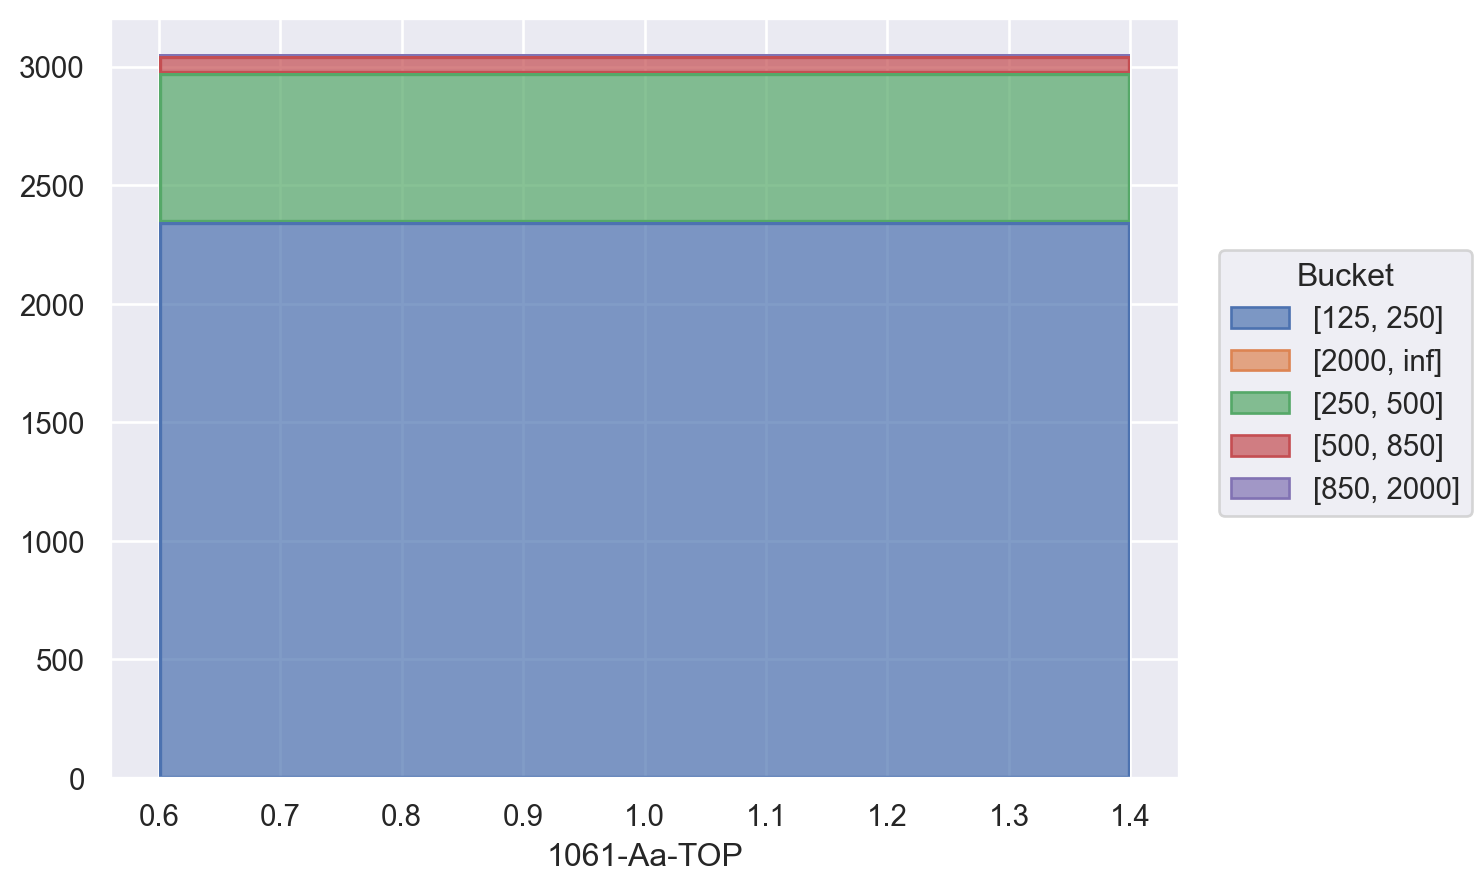

In [313]:
import seaborn as sns
from seaborn import objects as so

so.Plot(gr_df,x='1061-Aa-TOP',color='Bucket').add(so.Bar(), so.Count(), so.Stack())
#sns.histplot(datagr_size, bins = [63, 125,250,500,850,2000])
#plt.title("Longest axis (um)")

## Automate

In [154]:
import skimage
thresh_phase_otsu = skimage.filters.threshold_otsu(scan)
# thresh_cfp_otsu = skimage.filters.threshold_otsu(im_cfp_filt)

# Compare results to eyeballing it
# print("Phase by eye: ", thresh_phase, "   CFP by eye: ", thresh_cfp)


In [155]:
thresh_phase_otsu

27

In [158]:
print("Phase by Otsu:", thresh_phase_otsu, )

Phase by Otsu: 27


In [162]:
bacterial_area_pix = (scan > thresh_phase_otsu)#.sum()
bacterial_area_pix

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [ ]:
bacterial_area_pix